# Load

In [1]:
import sys
sys.path.append('../gym_art')

from PIL import Image

from paintings import PaintingEnv
import numpy as np
import pandas as pd
from collections import defaultdict, namedtuple, deque

from tqdm import tqdm
import seaborn as sns

In [2]:
env = PaintingEnv(state_type='object') # Outputs a top-layer of Inception with max-pooling

2022-02-10 22:04:24.742690: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import value_agent
from importlib import reload
value_agent = reload(value_agent)
Agent = value_agent.Agent

# Play

In [5]:
config_dict = {
    'seed': 42, 
    'buffer_size': int(1e2), 
    'batch_size': 32, 
    'gamma': 0.99, 
    'tau': 1e-2, 
    'loss_type': 'huber',
    'gradient_clip': None, 
    'update_every': 1, 
    'lr': 5e-4, 
    'fc1_units': 64, 
    'fc2_units': 32
}
agent = Agent(state_size=2048, action_size=1, config_dict=config_dict)

In [6]:
state, reward, done, info = env.reset(full_reset=False) # reset environment
pp_state = np.hstack(state)
action = 0
next_state, reward, done, info = env.step(action)
pp_next_state = np.hstack(next_state)

In [16]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
state = torch.from_numpy(pp_state).float().to(device)
state.shape

torch.Size([4096])

In [21]:
split_states = torch.t(state.view((-1,2))) # FIX
split_states.shape

torch.Size([2, 2048])

In [93]:
tmp = torch.t(split_states).unsqueeze(0)
tmp.shape

torch.Size([1, 2048, 2])

In [94]:
torch.tensor([0]).view((-1,1)).shape

torch.Size([1, 1])

In [100]:
tmp.shape

torch.Size([1, 2048, 2])

In [107]:
torch.vstack([ tmp, tmp ]).shape

torch.Size([2, 2048, 2])

In [108]:
tmp.unsqueeze(0).shape

torch.Size([1, 1, 2048, 2])

In [63]:
agent.qnetwork_local.eval()
with torch.no_grad():
    action_values = agent.qnetwork_local(split_states) # idea is that this would give the left right value
agent.qnetwork_local.train()

QNetwork(
  (fc1): Linear(in_features=2048, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [66]:
action_values.flip(0)

tensor([[0.1251],
        [0.0227]])

In [68]:
action = torch.argmax(action_values)

In [62]:
action_values

tensor([0.0227, 0.1251])

In [51]:
qdiff = action_values.flatten().diff()[0]
qdiff

tensor(0.1024)

In [50]:
action = 0 if qdiff > 0

tensor(-1.)

In [55]:
torch.diff(action_values.flatten(), )

RuntimeError: diff only supports n = 1 currently. Please file an issue at https://github.com/pytorch/pytorch/issues/new?assignees=&labels=&template=feature-request.md if your use case requires supporting higher-order differences

In [54]:
torch.diff?

Docstring:
diff(input, n=1, dim=-1, prepend=None, append=None) -> Tensor

Computes the n-th forward difference along the given dimension.

The first-order differences are given by `out[i] = input[i + 1] - input[i]`. Higher-order
differences are calculated by using :func:`torch.diff` recursively.

.. note::  Only `n = 1` is currently supported

Args:
    input (Tensor): the tensor to compute the differences on
    n (int, optional): the number of times to recursively compute the difference
    dim (int, optional): the dimension to compute the difference along.
        Default is the last dimension.
    prepend, append (Tensor, optional): values to prepend or append to
        :attr:`input` along :attr:`dim` before computing the difference.
        Their dimensions must be equivalent to that of input, and their shapes
        must match input's shape except on :attr:`dim`.

Keyword args:
    out (Tensor, optional): the output tensor.

Example::

    >>> a = torch.tensor([1, 3, 2])
    >>

In [111]:
experiences = agent.memory.sample()

In [112]:
states, actions, rewards, next_states, dones = experiences

In [114]:
split_states = states.view((agent.config['batch_size'],-1,2))

In [116]:
split_states.shape

torch.Size([32, 2048, 2])

In [123]:
states2 = torch.t(torch.hstack([ split_states[i,:,action] for i,action in enumerate(actions) ]))

In [124]:
states2.shape

torch.Size([32, 2048])

# Run

In [4]:
def dqn(agent, n_episodes=100, eps_start=1.0, eps_end=0.1, eps_decay=0.98, 
        ckpt_path='pth_checkpoints/checkpoint.pth'):
    """Deep Q-Learning.
    
    Params
    ======
        agent (Agent): The agent
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        train_mode (bool): if 'True' set environment to training mode
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    moving_avgs = []                   # list of moving averages
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state, reward, done, info = env.reset(full_reset=False) # reset environment
        score = 0
        for t in range(env.n_trials - 1):
            action = agent.act(state, eps)                         # select an action
            next_state, reward, done, info = env.step(action)      # send action to environment
            agent.step(state, action, reward, next_state, done) # learning step
            state = next_state
            score += reward
            if done:
                break
        mean_score = score/t # keep scores in range of 0-1, allow comparison to humans above
        scores_window.append(mean_score)          # save most recent score to window
        scores.append(mean_score)                 # save most recent score to total
        moving_avg = np.mean(scores_window)  # calculate moving average
        moving_avgs.append(moving_avg)       # save most recent moving average
        eps = max(eps_end, eps_decay*eps)    # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, moving_avg), end="")
        if i_episode % 5 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, moving_avg))
    return scores, moving_avgs

In [6]:
config_dict = {
    'seed': 42, 
    'buffer_size': int(1e2), 
    'batch_size': 32, 
    'gamma': 0.99, 
    'tau': 1e-2, 
    'loss_type': 'huber',
    'gradient_clip': None, 
    'update_every': 4, 
    'lr': 5e-4, 
    'fc1_units': 64, 
    'fc2_units': 32, 
    'use_ddqn': False,
    'use_dueling': False, 
    'use_per': False,
    'per_a': 0.5, 
    'per_beta': 0.5
}
agent = Agent(state_size=2048, action_size=1, config_dict=config_dict)
scores, avgs = dqn(agent, n_episodes=100, eps_decay=0.98, eps_end=0.1)

Episode 5	Average Score: 0.38
Episode 10	Average Score: 0.39
Episode 15	Average Score: 0.41
Episode 20	Average Score: 0.41
Episode 25	Average Score: 0.41
Episode 30	Average Score: 0.42
Episode 35	Average Score: 0.42
Episode 40	Average Score: 0.43
Episode 45	Average Score: 0.43
Episode 50	Average Score: 0.43
Episode 55	Average Score: 0.43
Episode 60	Average Score: 0.44
Episode 65	Average Score: 0.44
Episode 70	Average Score: 0.44
Episode 75	Average Score: 0.44
Episode 80	Average Score: 0.45
Episode 85	Average Score: 0.45
Episode 90	Average Score: 0.45
Episode 95	Average Score: 0.45
Episode 100	Average Score: 0.46


In [7]:
df = pd.DataFrame(dict(episode=np.arange(1, len(scores)+1), score=scores, moving_average=avgs))
df.head()

,episode,score,moving_average
0,1,0.386364,0.386364
1,2,0.381818,0.384091
2,3,0.395455,0.387879
3,4,0.400000,0.390909
4,5,0.359091,0.384545


/Users/czarrar/Dropbox/ABD/Areas/Lab_Work/paint_cats/myenv_paintcats/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


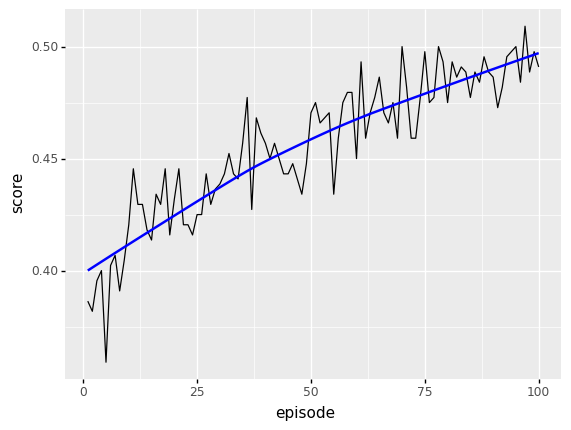

<ggplot: (8775828882553)>

In [9]:
import plotnine as pn
pn.ggplot(df, pn.aes(x='episode', y='score')) + pn.geom_line() + pn.geom_smooth(color='blue')